# Trabajo Práctico Nro. 2
## Mineria de Datos - 2024.
#### Tec. Universitaria en Inteligencia Artificial - FCEIA (UNR).

### Integrantes:
 * Pace, Bruno. Legajo: P-5295/7.
 * Sancho Almenar, Mariano. Legajo: S-5778/9.

[Link al repositorio](https://github.com/pace-bruno/TP2-Mineria-De-Datos)


In [1]:
# Manejo de datos
import pandas as pd
import numpy as np

# Gráficos
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source

# Modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Manejo de warnings
import warnings
warnings.filterwarnings('ignore')



### Carga y lectura de datasets

In [2]:
df_companies: pd.DataFrame = pd.read_csv('data/1000_Companies.csv')
df_pokemon: pd.DataFrame = pd.read_csv('data/PokemonDBCart.csv')

# **df_companies**


## Pre procesado *df_companies*

Sobre el dataframe se utilizará un arbol de decisión por regresión.


- EDA.
- Visualizaciones.
- Tratamiento de outliers.
- Normalización.

### Inspección

Como era de esperarse por el título del archivo, tenemos 1000 datos.

In [3]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [4]:
df_companies.sample(10)

,RyD_Spend,Administration,MarketingSpend,State,Profit
449,27745.0,114554.6036,122313.0924,Florida,72735.21323
811,138546.0,130918.2000,336103.9245,Florida,167391.55140
462,159134.0,133958.7296,375828.5267,New York,184979.70220
316,129325.0,129556.4007,318311.9798,Florida,159514.13070
330,50634.0,117934.9554,166477.4805,California,92289.08842
599,132449.0,130017.7672,324339.7464,Florida,162182.93690
468,18790.0,113232.0884,105034.3955,New York,65085.03400
199,52714.0,118242.1392,170490.8461,California,94066.01447
369,66102.0,120219.3401,196323.0287,New York,105503.26730
262,51407.0,118049.1155,167968.9861,California,92949.45565


### Chequeo de decimales

Se observa que en la columna 'RyD_Spend' hay decimales que son 0. Analizamos si hay algunos que no lo sean.

In [5]:
def check_decimals(x: float) -> bool:
    """
    Función auxiliar para determinar si un numero tiene o no parte decimal mayor a 0.
    """
    decimals = x - int(x)
    return decimals != 0

In [6]:
df_companies['decimals_ryd_spend'] = df_companies['RyD_Spend'].apply(check_decimals)

In [7]:
df_companies['decimals_ryd_spend'].value_counts()

decimals_ryd_spend
False    949
True      51
Name: count, dtype: int64

Se corrobora que en la columna 'RyD_Spend' existen decimales distintos de cero.

Por lo tanto, la columna creada es eliminada.

In [8]:
df_companies = df_companies.drop('decimals_ryd_spend', axis=1)

Chequeamos que las columnas que quedaron son las originales.

In [9]:
df_companies.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit'], dtype='object')

In [10]:
df_companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


Vemos que hay demasiados decimales que no aportan información extra. Por simplicidad y prolijidad, redondeamos a dos decimales las columnas numericas de tipo float.

In [11]:
df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']] = df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].apply(lambda x: round(x,2))

### Valores Faltantes

In [12]:
df_companies.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

No hay valores faltantes, por ende, continuamos con el análisis.

### Visualizaciones

In [13]:
px.box(df_companies[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']], 
    title='Boxplot de las variables de compañias')

In [14]:
fig_scatter_total = px.scatter(df_companies.drop(columns=['State']), title='Variables en función de sus índices.')
fig_scatter_total.show()

A partir del boxplot y el scatterplot podemos ver que hay potenciales outliers en las columnas Administration, Profit y MarketingSpend. 

In [15]:
px.histogram(
    df_companies[['RyD_Spend','Administration','MarketingSpend', 'Profit']],
    title = 'Distribuciones de las variables', text_auto=True
)

- Administration tiene una distribución que tiende a normal normal.
- Las demás variables tienen distribuciones que tienen a ser uniformes, con algunos outliers.

### Valores atípicos

In [16]:
df_companies[['Administration', 'Profit']].describe()

,Administration,Profit
count,1000.000000,1000.000000
mean,122963.897650,119546.164700
std,12613.927637,42888.633878
min,51283.140000,14681.400000
25%,116640.685000,85943.200000
50%,122421.610000,117641.465000
75%,129139.117500,155577.107500
max,321652.140000,476485.430000


In [17]:
administration_quantile_99: float = df_companies['Administration'].quantile(.99)
administration_quantile_01: float = df_companies['Administration'].quantile(.01)
profit_quantile_99: float = df_companies['Profit'].quantile(.99)
marketing_quantile_99: float = df_companies['MarketingSpend'].quantile(.99)

print(f'El cuantil 0.99 de Administration es: {round(administration_quantile_99,2)}')
print(f'El cuantil 0.01 de Administration: {round(administration_quantile_01,2)}')
print(f'El cuantil 0.99 de Profit es: {round(profit_quantile_99,2)}')
print(f'El cuantil 0.99 de MarketingSpend es: {round(marketing_quantile_99,2)}')

El cuantil 0.99 de Administration es: 152705.22
El cuantil 0.01 de Administration: 99809.38
El cuantil 0.99 de Profit es: 185033.03
El cuantil 0.99 de MarketingSpend es: 375829.63


In [18]:
df_companies_outliers: pd.DataFrame = df_companies.loc[
    (df_companies['Administration'] > administration_quantile_99) |
    (df_companies['Administration'] < administration_quantile_01) |
    (df_companies['Profit'] > profit_quantile_99) |
    (df_companies['MarketingSpend'] > marketing_quantile_99)
]

print(df_companies_outliers.info())

df_companies_outliers

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       30 non-null     float64
 1   Administration  30 non-null     float64
 2   MarketingSpend  30 non-null     float64
 3   State           30 non-null     object 
 4   Profit          30 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.4+ KB
None


,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94
11,100671.96,91790.61,249744.55,California,144259.40
14,119943.24,156547.42,256512.92,Florida,132602.65
19,86419.70,153514.11,0.00,New York,122776.86
21,78389.47,153773.43,299737.29,New York,111313.02
24,77044.01,99281.34,140574.81,New York,108552.04


Los potenciales outliers son sólo 30 casos. Previo a adoptar una estrategia se realiza su scatterplot.

In [19]:
fig2 = px.scatter(df_companies_outliers.drop(columns=['State']), title='Variables en función de sus índices.')
fig2.show()

La variable **MarketingSpend** posee outliers que son en los datos de índices más bajos, hasta el índice 4. Desde el 4 en adelante, consideramos que para esta columna, no tenemos outliers.

Al evaluar la variable **Administration**, se observa que si bien hay valores por encima del quantile 0.99 y por debajo del quantil 0.01, no están desfasados de sus demás gastos y de las ganancias producidas. 

Con respecto a **Profit**, consideramos que los valores de los índices 997 al 999, son outliers. Como son solo 3, decidimos dropearlos.

La estrategia a adoptar, considerando la poca cantidad de datos outliers, es cambiarlos por la mediana.

In [20]:
# extracción de índices.
outliers_index: list[int] = df_companies_outliers.index[df_companies_outliers.index < 958].tolist() 

df_companies_filtered: pd.DataFrame = df_companies.copy()

# imputación.
df_companies_filtered['MarketingSpend'].loc[
    df_companies['MarketingSpend'] > marketing_quantile_99
] = df_companies_filtered['MarketingSpend'].median()

 #chequeo que no queden outliers.
df_companies_filtered['MarketingSpend'].loc[
    df_companies_filtered['MarketingSpend'] > marketing_quantile_99
    ]

Series([], Name: MarketingSpend, dtype: float64)

In [21]:
df_companies_filtered = df_companies_filtered[:996]

#chequeo de extracción
df_companies_filtered.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       996 non-null    float64
 1   Administration  996 non-null    float64
 2   MarketingSpend  996 non-null    float64
 3   State           996 non-null    object 
 4   Profit          996 non-null    float64
dtypes: float64(4), object(1)
memory usage: 39.0+ KB


In [22]:
corr_matrix = df_companies_filtered[
    ['RyD_Spend','Administration','MarketingSpend', 'Profit']].corr()
px.imshow(corr_matrix,
          text_auto=True,
          aspect='auto',
          zmin=-1,
          zmax=1, title= 'Matriz de Correlación')

Vemos correlaciones fuertes:
 - Profit - MarketingSpend.
 - Profit - RyD_Spend.
 - MarketingSpend - RyDSpend.

 Hay una correlación que no es particularmente fuerte pero que es de destacar:
 - Profit - Administration.

 Analizando esto con el contexto que tenemos de las ganancias de las empresas con respecto a los gastos de Marketing y Desarrollo, no es descabellado pensar que mientras más se inviertan en estas áreas, más reditos económicos podemos conseguir. 
 Vemos una tendencia que a medida que se gasta más en personal de administración, más se gana.

### Columna 'State'

In [23]:
fig_scatter = px.box(df_companies, x='State', y='Profit',  title='Boxplot de las ganancias diferenciando los estados')
fig_scatter.show()

In [24]:
df_companies_filtered['State'].value_counts()

State
California    341
New York      333
Florida       322
Name: count, dtype: int64

Observamos que los estados están casi balanceados.

Se observa que la columna 'State' no influye en las ganancias finales dado que tienen valores similares. Es por eso que se decide no considerarla para el modelo de predicción.


## Separación de conjuntos train-test

Se obtiene dos conjuntos train-test para la comparación de resultados

In [25]:
X: pd.DataFrame = df_companies_filtered.drop(columns=['Profit'], axis=1)
y: pd.DataFrame = pd.DataFrame(df_companies_filtered['Profit'], columns=['Profit'])

Se utilizan random states distintos para tener dos conjuntos de datos diferentes, pero del mismo tamaño.

In [26]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [27]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=17
)


## Estandarización

Se utiliza el método de Z-score para la estandarización de los conjuntos


### Conjunto 1

In [28]:
X1_train_std = X1_train.drop(columns=['State'])
X1_test_std = X1_test.drop(columns=['State'])
# y1_train_std = y1_train.to_frame()

In [29]:
scaler1_x: StandardScaler = StandardScaler()
scaler1_y: StandardScaler = StandardScaler()

In [30]:
# Fit modelo de estandarización conjunto 1

X1_train_std: pd.DataFrame = pd.DataFrame(scaler1_x.fit_transform(X1_train_std), columns=X1_train_std.columns)
y1_train_std: pd.DataFrame = pd.DataFrame(scaler1_y.fit_transform(y1_train), columns=y1_train.columns)

In [31]:
# Estandarización conjuntos de test

X1_test_std: pd.DataFrame = pd.DataFrame(scaler1_x.transform(X1_test_std), columns=X1_test_std.columns)
y1_test_std: pd.DataFrame = pd.DataFrame(scaler1_y.transform(y1_test), columns=y1_test.columns)

In [32]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X1_train_std = pd.concat([X1_train_std, X1_train['State']], axis=1)
# X1_test_std = pd.concat([X1_test_std, X1_test['State']], axis=1)


### Conjunto 2

In [33]:
X2_train_std = X2_train.drop(columns=['State'])
X2_test_std = X2_test.drop(columns=['State'])

In [34]:
scaler2_x: StandardScaler = StandardScaler()
scaler2_y: StandardScaler = StandardScaler()

In [35]:
# Fit modelo de estandarización conjunto 1

X2_train_std: pd.DataFrame = pd.DataFrame(scaler2_x.fit_transform(X2_train_std), columns=X2_train_std.columns)
y2_train_std: pd.DataFrame = pd.DataFrame(scaler2_y.fit_transform(y2_train), columns=y2_train.columns)

In [36]:
# Estandarización conjuntos de test

X2_test_std: pd.DataFrame = pd.DataFrame(scaler2_x.transform(X2_test_std), columns=X2_test_std.columns)
y2_test_std: pd.DataFrame = pd.DataFrame(scaler2_y.transform(y2_test), columns=y2_test.columns)

In [37]:
# Se vuelve a agregar al columna categórica a los conjuntos X

# X2_train_std = pd.concat([X2_train_std, X2_train['State']], axis=1)
# X2_test_std = pd.concat([X2_test_std, X2_test['State']], axis=1)


## Modelos: Árboles de decisión (Regresión) 

Para el dataframe de las 1000 companías, se realizarán predicciones para la variable 'Profit' utilizando árboles de decisión por regresión.

En una primera instancia, se compara un modelo base de árbol con uno con parámetros específicos. 


### Modelo base usando los parámetros por defecto

In [38]:
tree_reg_base = DecisionTreeRegressor()

In [39]:
tree_reg_base.fit(X1_train_std, y1_train_std)

DecisionTreeRegressor()

In [40]:
y1_predict = tree_reg_base.predict(X1_test_std)


#### Obtención de métricas

In [41]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, y1_predict))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, y1_predict))
print("R2 Score:", r2_score(y1_test_std, y1_predict))

Mean Absolute Error (MAE): 0.005397071028669165
Mean Squared Error (MSE): 0.00045963110155215655
R2 Score: 0.999541712838846



#### Visualización

In [42]:
tree = export_graphviz(
        tree_reg_base, 
        out_file=None, 
        feature_names=X1_test_std.columns,
        class_names=y, 
        rounded=True, 
        filled=True)



print(f"Profundidad del árbol: {tree_reg_base.get_depth()}")
print(f"Número de hojas: {tree_reg_base.get_n_leaves()}")
print(f"Número total de nodos: {tree_reg_base.tree_.node_count}")
graphviz.Source(tree)

Profundidad del árbol: 14
Número de hojas: 795
Número total de nodos: 1589


A partir de las métricas obtenidas y la visualización del árbol, donde se observa una gran cantidad de hojas y profundidad, podemos asumir que el modelo base presenta un **sobreajuste**.

Se variará la profundidad, el número  mínimo  de  observaciones,  el número mínimo de observaciones por separación y  un criterio de separación.

Se compararán los resultados con respecto al modelo base.

In [43]:
# Definir una lista de valores para los parámetros de optimización
max_depths: list[None | int] = [2, 3, 4]
min_samples_splits: list[int] = [2, 3, 4]
min_samples_leaves: list[int] = [2]
criterios: list[str] = ['squared_error', 'friedman_mse', 'absolute_error'] 
results: list[dict] = []

for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leaves:
            for criterio in criterios:
            
                tree_reg = DecisionTreeRegressor(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    criterion=criterio,
                    random_state=42
                )

                tree_reg.fit(X1_train_std, y1_train_std)
                
                y1_pred = tree_reg.predict(X1_test_std)
                
                mae = mean_absolute_error(y1_test_std, y1_pred)
                r2 = r2_score(y1_test_std, y1_pred)
                
                results.append({
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'criterio': criterio,
                    'MAE': mae,
                    'R²': r2
                    })

results_df = pd.DataFrame(results)

# Seleccionamos el modelo con mejor R².
best_model = results_df.loc[results_df['R²'].idxmax()]
print("Mejor modelo encontrado:")
print(best_model)


Mejor modelo encontrado:
max_depth                         4
min_samples_split                 2
min_samples_leaf                  2
criterio             absolute_error
MAE                        0.057109
R²                         0.995448
Name: 20, dtype: object



### Mejor modelo para el conjunto 1

Mean Absolute Error (MAE): 0.05956267953277261
Mean Squared Error (MSE): 0.004764711444659079
R² Score: 0.9952492203545034
------------------------
Profundidad del árbol: 4
Número de hojas: 16
Número total de nodos: 31


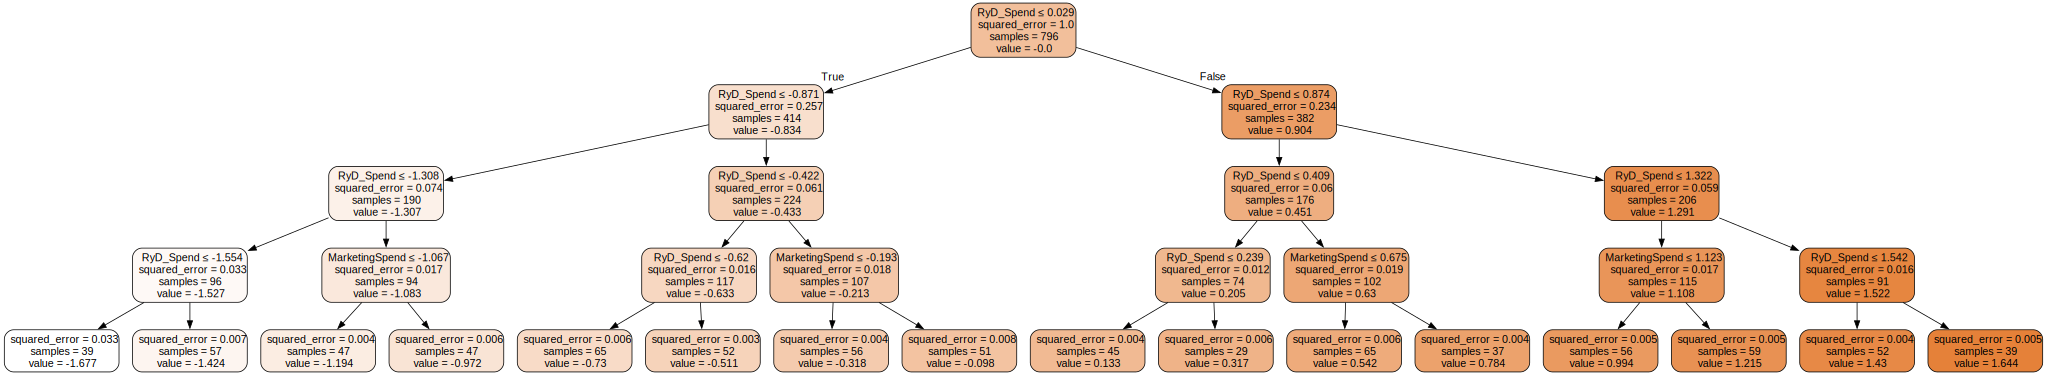

In [44]:
best_tree_reg = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg.fit(X1_train_std, y1_train_std)

dot_data = export_graphviz(best_tree_reg, 
                           out_file=None, 
                           feature_names=X1_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y1_pred = best_tree_reg.predict(X1_test_std)

# Obtención de la métricas del mejor modelo en el conjunto 1
print("Mean Absolute Error (MAE):", mean_absolute_error(y1_test_std, best_y1_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y1_test_std, best_y1_pred))
print("R² Score:", r2_score(y1_test_std, best_y1_pred))
print("------------------------")
print(f"Profundidad del árbol: {best_tree_reg.get_depth()}")
print(f"Número de hojas: {best_tree_reg.get_n_leaves()}")
print(f"Número total de nodos: {best_tree_reg.tree_.node_count}")

graphviz.Source(dot_data)  


### Mejor modelo para el conjunto 2

Mean Absolute Error (MAE): 0.059734828779947756
Mean Squared Error (MSE): 0.005435830182079604
R² Score: 0.9944483093221492
Profundidad del árbol: 4
Número de hojas: 16
Número total de nodos: 31


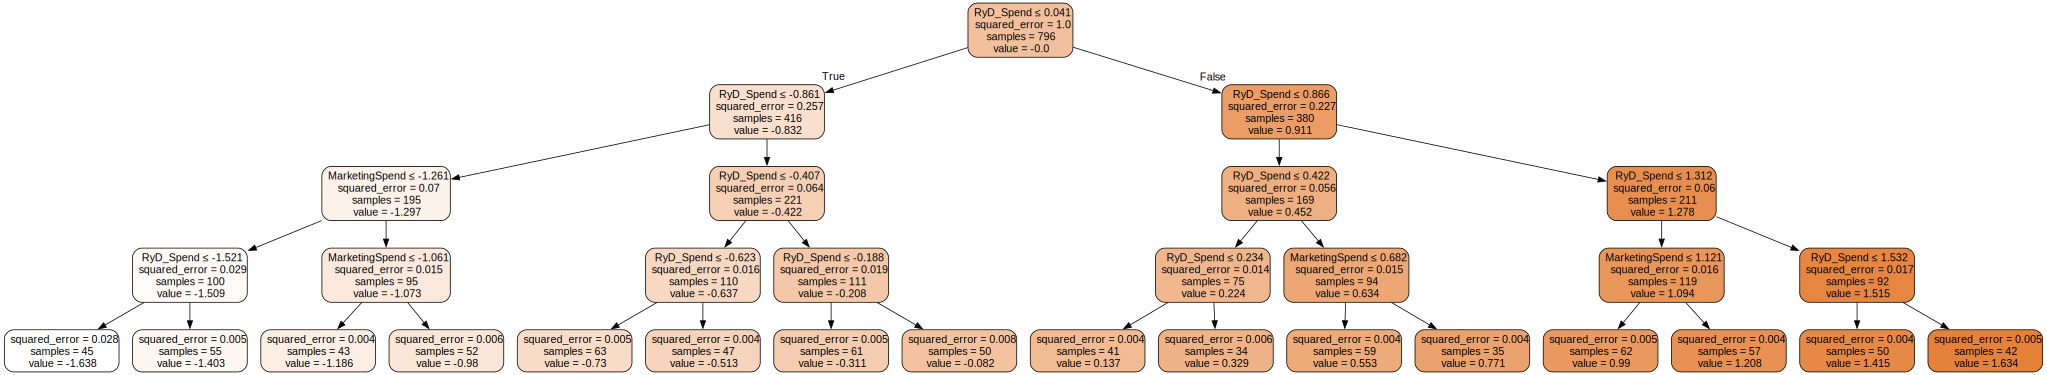

In [45]:
best_tree_reg2 = DecisionTreeRegressor(
    max_depth=int(best_model['max_depth']),
    min_samples_split=best_model['min_samples_split'],
    min_samples_leaf=best_model['min_samples_leaf'],
    random_state=42
)

best_tree_reg2.fit(X2_train_std, y2_train_std)


dot_data = export_graphviz(best_tree_reg2, 
                           out_file=None, 
                           feature_names=X2_train_std.columns,
                           filled=True, 
                           rounded=True,  
                           special_characters=True)

best_y2_pred = best_tree_reg.predict(X2_test_std)

# Obtención de métricas del mejor modelo en el conjunto 2
print("Mean Absolute Error (MAE):", mean_absolute_error(y2_test_std, best_y2_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y2_test_std, best_y2_pred))
print("R² Score:", r2_score(y2_test_std, best_y2_pred))

print(f"Profundidad del árbol: {best_tree_reg2.get_depth()}")
print(f"Número de hojas: {best_tree_reg2.get_n_leaves()}")
print(f"Número total de nodos: {best_tree_reg2.tree_.node_count}")

graphviz.Source(dot_data)  

Para ambos conjuntos se presentan arboles con resultados similares entre sí y métricas cercanas a las del modelo base. Si bien el rendimiento del árbol es comparable con el del modelo base, los mismos cuentan con menor profundidad y hojas.


# **df_pokemon**

## Pre procesado *df_pokemon*

Sobre el dataframe se utilizará un arbol de decisión por regresión.


- EDA.
- Visualizaciones.
- Tratamiento de outliers.
- Normalización.

Inspección de tipos de datos. Nos encontramos frente a un dataset con 479 datos, lo cual es escaso.

In [46]:
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Nombre       479 non-null    object
 1   Ataque       479 non-null    int64 
 2   Defensa      479 non-null    int64 
 3   Velocidad    479 non-null    int64 
 4   HP           479 non-null    int64 
 5   SpAtaque     479 non-null    int64 
 6   SpDefensa    479 non-null    int64 
 7   TipoPokemon  479 non-null    object
dtypes: int64(6), object(2)
memory usage: 30.1+ KB


Muestra del dataset.

In [47]:
df_pokemon.sample(5)

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
298,Manaphy,100,100,100,100,100,100,agua
295,Heatran,90,106,77,91,130,106,fuego
134,Ursaring,130,75,55,90,75,75,normal
294,Palkia,120,100,100,90,150,120,agua
129,Forretress,90,140,40,75,60,60,bicho


### Valores Faltantes

No hay datos faltantes.

In [48]:
df_pokemon.isna().sum()

Nombre         0
Ataque         0
Defensa        0
Velocidad      0
HP             0
SpAtaque       0
SpDefensa      0
TipoPokemon    0
dtype: int64

### Balance de la columna 'TipoPokemon'

Observamos una noción del estado del balanceo (o desbalanceo con respecto a TipoPokemon)

In [49]:
df_pokemon['TipoPokemon'].value_counts()

TipoPokemon
agua         80
hierba       78
bicho        72
normal       60
psiquico     53
fuego        52
roca         45
electrico    39
Name: count, dtype: int64

In [50]:
px.histogram(
    df_pokemon['TipoPokemon'],
    title = 'Histograma de la variable target TipoPokemon'
)

El dataset presenta un leve desbalanceo, se destaca la presencia de mayores valores de Pokemones de tipo Hierba, Agua y Bicho. No se opta por la opción de balancear los datos.

### Visualizaciones

Boxplot de cada variable

In [51]:
px.box(df_pokemon[['Ataque','Defensa','Velocidad','HP','SpAtaque','SpDefensa']], title='Boxplot de las variables')

Matriz de Correlación

Observamos correlación entre las variables de la base de datos de pokemon. 

In [52]:
corr_matrix_pokemon = df_pokemon.drop(columns=['Nombre', 'TipoPokemon']).corr()

px.imshow(corr_matrix_pokemon, zmin=-1, zmax=1, title='Correlación de variables Pokemon', text_auto=True, aspect='auto')

Vemos que no existen correlaciones fuertes entre las variables.

Se evalúa que de forma potencial todas las variables tienen outliers. 

In [53]:
px.histogram(df_pokemon.drop(columns=['TipoPokemon', 'Nombre']), 
                                   title='Distribucion de las variables de los pokemons', 
                                   text_auto=True)

El dataset cuenta con ditribuciones normales con un leve sesgo hacia la derecha

### Análisis de valores atípicos

In [54]:
df_pokemon_outliers = df_pokemon.loc[
    (df_pokemon['Ataque'] > df_pokemon['Ataque'].quantile(0.99)) |
    (df_pokemon['Defensa'] > df_pokemon['Defensa'].quantile(0.99)) |
    (df_pokemon['Velocidad'] > df_pokemon['Velocidad'].quantile(0.99)) |
    ((df_pokemon['HP'] > df_pokemon['HP'].quantile(0.99)) | (df_pokemon['HP'] < df_pokemon['HP'].quantile(0.01))) |
    (df_pokemon['SpAtaque'] > df_pokemon['SpAtaque'].quantile(0.99)) |
    (df_pokemon['SpDefensa'] > df_pokemon['SpDefensa'].quantile(0.99))
]

print(df_pokemon_outliers.info())

df_pokemon_outliers

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 38 to 477
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Nombre       28 non-null     object
 1   Ataque       28 non-null     int64 
 2   Defensa      28 non-null     int64 
 3   Velocidad    28 non-null     int64 
 4   HP           28 non-null     int64 
 5   SpAtaque     28 non-null     int64 
 6   SpDefensa    28 non-null     int64 
 7   TipoPokemon  28 non-null     object
dtypes: int64(6), object(2)
memory usage: 2.0+ KB
None


,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
38,Alakazam,50,65,150,55,175,105,psiquico
57,Onix,45,160,70,35,30,45,roca
89,Mewtwo,150,70,140,106,194,120,psiquico
108,Pichu,40,15,60,20,35,35,electrico
127,Wobbuffet,33,58,33,190,33,58,psiquico
132,Shuckle,10,230,5,20,10,230,bicho
133,Heracross,185,115,75,80,40,105,bicho
145,Blissey,10,10,55,255,75,135,normal
151,Tyranitar,164,150,71,100,95,120,roca
152,Lugia,90,130,110,106,90,154,psiquico


Se observa que dado que el total de los datos son 479 y que los 28 outliers representan un 5.84% del total, se procede a imputar por la media. Se intenta conservar la mayor integridad y representatividad de los datos.

In [55]:
numerical_columns: list[str] = ['Ataque', 'Defensa', 'Velocidad', 'HP', 'SpAtaque', 'SpDefensa'] # lista de columnas para iterar

Seteo las columans a nan para imputar facilmente.

In [56]:
for column in numerical_columns:
    df_pokemon_outliers[column] = np.nan #seteo cada columna a valores nan

df_pokemon_outliers

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
38,Alakazam,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
57,Onix,NaN,NaN,NaN,NaN,NaN,NaN,roca
89,Mewtwo,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
108,Pichu,NaN,NaN,NaN,NaN,NaN,NaN,electrico
127,Wobbuffet,NaN,NaN,NaN,NaN,NaN,NaN,psiquico
132,Shuckle,NaN,NaN,NaN,NaN,NaN,NaN,bicho
133,Heracross,NaN,NaN,NaN,NaN,NaN,NaN,bicho
145,Blissey,NaN,NaN,NaN,NaN,NaN,NaN,normal
151,Tyranitar,NaN,NaN,NaN,NaN,NaN,NaN,roca
152,Lugia,NaN,NaN,NaN,NaN,NaN,NaN,psiquico


Chequeo imputación nan.

In [57]:
df_pokemon_outliers[numerical_columns].isna().sum()

Ataque       28
Defensa      28
Velocidad    28
HP           28
SpAtaque     28
SpDefensa    28
dtype: int64

Se imputa por la mediana teniendo en cuenta el tipo de Pokemon

In [58]:
mediana_por_clase = df_pokemon[numerical_columns].groupby(df_pokemon['TipoPokemon']).transform('median')

df_pokemon_outliers[numerical_columns] = df_pokemon_outliers[numerical_columns].fillna(mediana_por_clase)

In [59]:
df_pokemon_outliers.sample(5)

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
57,Onix,89.0,95.0,51.0,67.0,55.0,65.0,roca
89,Mewtwo,55.0,65.0,79.0,68.0,95.0,89.0,psiquico
151,Tyranitar,89.0,95.0,51.0,67.0,55.0,65.0,roca
475,Pheromosa,65.0,60.0,58.5,60.0,51.5,55.5,bicho
288,Gallade,55.0,65.0,79.0,68.0,95.0,89.0,psiquico


Creo una lista de índices para facilitar el trabajo de remoción de los outliers del df original y agregado de los datos faltantes.

In [60]:
list_index: list[int] = df_pokemon_outliers.index.tolist()

### Unión de valores imputados al dataset original

In [61]:
df_pokemon_final: pd.DataFrame = df_pokemon.copy()

df_pokemon_final = df_pokemon_final.drop(list_index)

df_pokemon_final = pd.concat([df_pokemon_final, df_pokemon_outliers], join='outer')

In [62]:
df_pokemon_final

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49.0,49.0,45.0,45.0,65.0,65.0,hierba
1,Ivysaur,62.0,63.0,60.0,60.0,80.0,80.0,hierba
2,Venusaur,100.0,123.0,80.0,80.0,122.0,120.0,hierba
3,Charmander,52.0,43.0,65.0,39.0,60.0,50.0,fuego
4,Charmeleon,64.0,58.0,80.0,58.0,80.0,65.0,fuego
...,...,...,...,...,...,...,...,...
420,Carbink,89.0,95.0,51.0,67.0,55.0,65.0,roca
422,Hoopa,55.0,65.0,79.0,68.0,95.0,89.0,psiquico
475,Pheromosa,65.0,60.0,58.5,60.0,51.5,55.5,bicho
476,Xurkitree,65.0,60.0,95.0,60.0,81.0,73.0,electrico


### Análisis de Duplicados

In [63]:
df_pokemon_final.duplicated().sum()

np.int64(0)

No se encuentran datos duplicados

## División de datos pokemon
Se divide el dataset en dos pares de conjuntos:
- El primer par en 80% de datos para entrenar el modelo y 20% testo.
- El segundo par en 70% de datos para entrenar el modelo y 30% testeo.  

Defino mi dataset **'y_pokemon' como la columna 'TipoPokemon'** y **'X_pokemon' como las columnas restantes**.
Se decidió dropear la columna 'Nombre', porque se considera no aportar información relevante.

*El dataset 'X' tiene las columnas restantes:*
- Ataque
- Defensa 
- Velocidad 
- HP 
- SpAtaque 
- SpDefensa 


In [64]:
X_pokemon = df_pokemon_final.drop(['TipoPokemon', 'Nombre'], axis=1)
y_pokemon = df_pokemon_final['TipoPokemon']

Separo en dos 4-tuplas de datasets de test y train:
- La primera tiene destinado un 80% de los datos para training y 20% para test.
- La segunda tiene destinado un 70% de los datos para training y 30% para test.

In [65]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_pokemon, y_pokemon, test_size=0.2, random_state=42) 

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_pokemon, y_pokemon, test_size=0.3, random_state=42)

Aplicamos estandarización para escalar el modelo con Z-Score. Se realiza posterior a la separación para no sesgar los datos de test. 
Los datasets de las variables target no serán estandarizadas ya que son dummies.

In [66]:
X_80: StandardScaler = StandardScaler()
X_70: StandardScaler = StandardScaler()

Se aplica Z-Score con el mismo criterio en ambos casos, evitando sesgos.

In [67]:
X_train_80_std: pd.DataFrame = pd.DataFrame(X_80.fit_transform(X_train_80), columns=X_train_80.columns)

X_test_20_std: pd.DataFrame = pd.DataFrame(X_80.transform(X_test_20), columns=X_test_20.columns)

X_train_70_std: pd.DataFrame = pd.DataFrame(X_70.fit_transform(X_train_70), columns=X_train_70.columns)

X_test_30_std: pd.DataFrame = pd.DataFrame(X_70.transform(X_test_30), columns=X_test_30.columns)

## Modelado de datos pokemon

### Modelado: Tree decision classifier.

En esta ocasión optamos por trabajar con un arbol de decisión para clasificación. 

In [68]:
tree_class_pokemon_80:  DecisionTreeClassifier =  DecisionTreeClassifier(random_state=42, class_weight='balanced')

tree_class_pokemon_70:  DecisionTreeClassifier =  DecisionTreeClassifier(random_state=42, class_weight='balanced')

parametros = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 20],
    'min_samples_leaf': [1, 2, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10]
}


Aplico GridSearchCV para el el arbol de decisión de clasificación para el primer conjunto de datos (80% train, 20% test)

Información de la estructura del árbol:

Profundidad del árbol: 8
Número de hojas: 48
Número total de nodos: 95
--------------------------------------------------------------------------------

Precision score: 0.4060921717171717
Recall score: 0.34375
accuracy_score: 0.34375


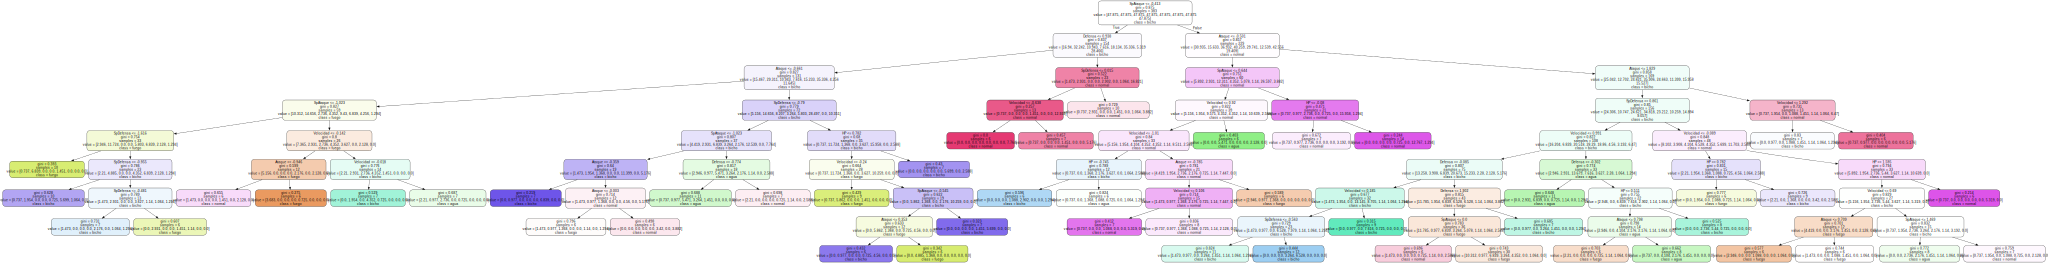

In [69]:
grid_pokemon_80: GridSearchCV = GridSearchCV(tree_class_pokemon_80,parametros, cv=5, scoring='accuracy', n_jobs=-1)

grid_pokemon_80.fit(X_train_80_std, y_train_80)

y_predict_20 = grid_pokemon_80.predict(X_test_20_std)

tree_pokemon_80 = grid_pokemon_80.best_estimator_

export_graphviz(tree_pokemon_80, out_file='tree_class_pokemon_80.dot', 
                feature_names=X_train_80_std.columns, 
                class_names=y_test_20,
                filled=True, rounded=True, proportion=False)


print("Información de la estructura del árbol:\n")
print(f"Profundidad del árbol: {tree_pokemon_80.get_depth()}")
print(f"Número de hojas: {tree_pokemon_80.get_n_leaves()}")
print(f"Número total de nodos: {tree_pokemon_80.tree_.node_count}")

print("--------------------------------------------------------------------------------\n")
print(f'Precision score: {precision_score(y_test_20, y_predict_20, average='weighted')}')
print(f'Recall score: {recall_score(y_test_20, y_predict_20, average='weighted')}')
print(f'accuracy_score: {accuracy_score(y_test_20, y_predict_20)}')

Source.from_file('tree_class_pokemon_80.dot')

Realizo la matriz de confusión para tener una visualización del rendimiento del modelo.

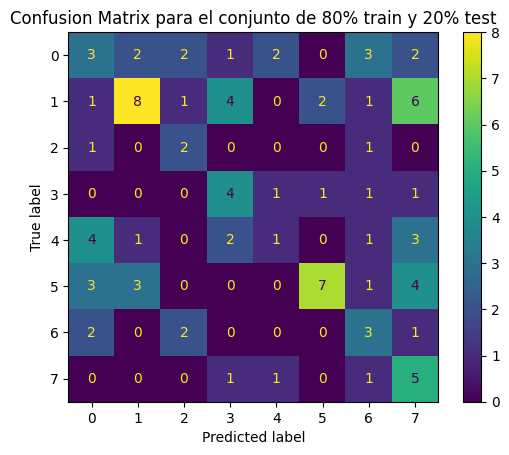

In [70]:
confusion_matrix_80 = confusion_matrix(y_test_20, y_predict_20)

ConfusionMatrixDisplay(confusion_matrix_80).plot()
plt.title('Confusion Matrix para el conjunto de 80% train y 20% test');

Como podemos observar, el modelo tiene un bajo rendimiento. Las métricas dan valores demasiado bajos y la matriz de confusión ilustra.

Aplico GridSearchCV para el el arbol de decisión de clasificación para el primer conjunto de datos (70% train, 30% test)

Información de la estructura del árbol:

Profundidad del árbol: 7
Número de hojas: 27
Número total de nodos: 53
--------------------------------------------------------------------------------

Precision score: 0.37260899730262476
Recall score: 0.3263888888888889
accuracy_score: 0.3263888888888889


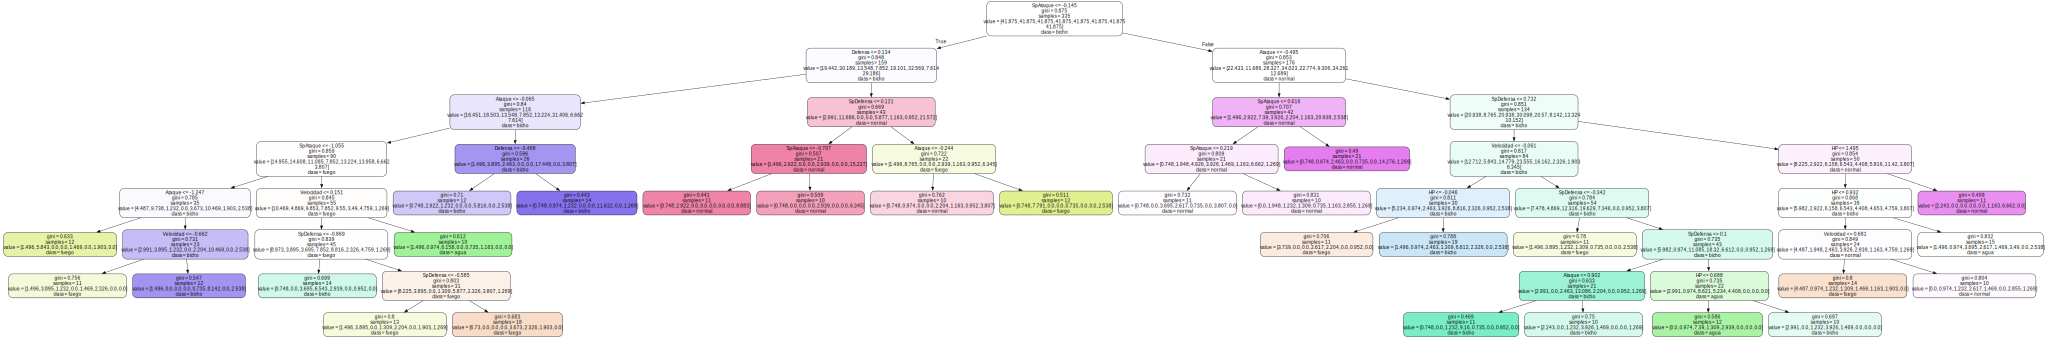

In [71]:
grid_pokemon_70: GridSearchCV = GridSearchCV(tree_class_pokemon_70,parametros, cv=10, scoring='accuracy', n_jobs=-1)

grid_pokemon_70.fit(X_train_70_std, y_train_70) 

y_predict_30 = grid_pokemon_70.predict(X_test_30_std)

tree_pokemon_70 = grid_pokemon_70.best_estimator_

export_graphviz(tree_pokemon_70, out_file='tree_class_pokemon_70.dot', 
                feature_names=X_train_80_std.columns, 
                class_names=y_test_20,
                filled=True, rounded=True, proportion=False)


print("Información de la estructura del árbol:\n")
print(f"Profundidad del árbol: {tree_pokemon_70.get_depth()}")
print(f"Número de hojas: {tree_pokemon_70.get_n_leaves()}")
print(f"Número total de nodos: {tree_pokemon_70.tree_.node_count}")

print("--------------------------------------------------------------------------------\n")
print(f'Precision score: {precision_score(y_test_30, y_predict_30, average='weighted')}')
print(f'Recall score: {recall_score(y_test_30, y_predict_30, average='weighted')}')
print(f'accuracy_score: {accuracy_score(y_test_30, y_predict_30)}')

Source.from_file('tree_class_pokemon_70.dot')

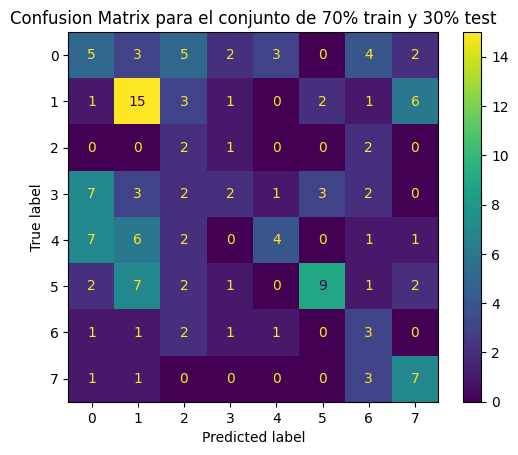

In [72]:
confusion_matrix_70 = confusion_matrix(y_test_30, y_predict_30)

ConfusionMatrixDisplay(confusion_matrix_70).plot()
plt.title('Confusion Matrix para el conjunto de 70% train y 30% test');

Vemos que el rendimiento es aún inferior, pero de forma sutil. Definitivamente este modelo, no es acorde a los datos que presenta nuestro problema.

### Modelado: Bayes Ingenuo

Se utiliza el modelo de Bayes Ingenuo para predecir el tipo de Pokemon. Se optó por el método Gaussiano, ya que las distribuciones de los datos tienden a ser normales.

Incialización del modelo.

In [73]:
bayes_ingenuo_80_gaussian: GaussianNB = GaussianNB()
bayes_ingenuo_70_gaussian: GaussianNB = GaussianNB()

Análisis de rendimiento para el modelo de bayes para el dataset 80-20.

Precision score: 0.30294526143790845
Recall score: 0.3349184782608695
accuracy_score: 0.3229166666666667


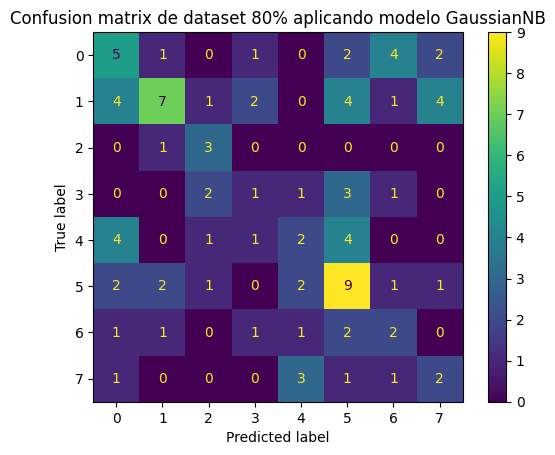

In [74]:
bayes_ingenuo_80_gaussian.fit(X_train_80_std, y_train_80)

y_pred_bayes_ingenuo_80_gaussian = bayes_ingenuo_80_gaussian.predict(X_test_20_std)

print(f'Precision score: {precision_score(y_test_20, y_pred_bayes_ingenuo_80_gaussian, average="macro")}')
print(f'Recall score: {recall_score(y_test_20, y_pred_bayes_ingenuo_80_gaussian, average="macro")}')
print(f'accuracy_score: {accuracy_score(y_test_20, y_pred_bayes_ingenuo_80_gaussian)}')

confusion_matrix_80_gaussian = confusion_matrix(y_test_20, y_pred_bayes_ingenuo_80_gaussian)
ConfusionMatrixDisplay(confusion_matrix_80_gaussian).plot()
plt.title('Confusion matrix de dataset 80% aplicando modelo GaussianNB');


Las métricas que presenta el modelo de bayes para esta 4-tupla es deficiente. En comparación con el modelo de árbol, tiene un rendimiento menor pero no significativo. 

Análisis de rendimiento para el modelo de bayes para el dataset 70-30.

Precision score: 0.27640345765345764
Recall score: 0.34683394909688015
accuracy_score: 0.2777777777777778


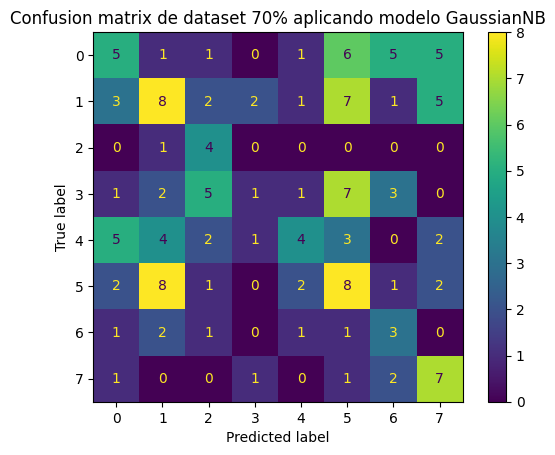

In [75]:
bayes_ingenuo_70_gaussian.fit(X_train_70_std, y_train_70)

y_pred_bayes_ingenuo_70_gaussian = bayes_ingenuo_70_gaussian.predict(X_test_30_std)

print(f'Precision score: {precision_score(y_test_30, y_pred_bayes_ingenuo_70_gaussian, average="macro")}')
print(f'Recall score: {recall_score(y_test_30, y_pred_bayes_ingenuo_70_gaussian, average="macro")}')
print(f'accuracy_score: {accuracy_score(y_test_30, y_pred_bayes_ingenuo_70_gaussian)}')

confusion_matrix_70_gaussian = confusion_matrix(y_test_30, y_pred_bayes_ingenuo_70_gaussian)
ConfusionMatrixDisplay(confusion_matrix_70_gaussian).plot()
plt.title('Confusion matrix de dataset 70% aplicando modelo GaussianNB');


No se presenta un escenario distinto para este caso, una vez más ilustra un rendimiento que no es útil para estos datos.

### Clasificación mediante KNN

Se utiliza GridSearchSV para la obtención de los mejores parámetros

In [76]:
def plot_classification_model(X, y, y_pred):
    """
    Función que reduce el conjunto de características X a 3 componentes con PCA y
    grafica en 3D las predicciones del modelo clasificadas por clase.
    """

    # Creación del modelo
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    pca_df['True Labels'] = y
    pca_df['Predictions'] = y_pred

    clases_unicas = pca_df['Predictions'].unique()
    color_map = {clase: i for i, clase in enumerate(clases_unicas)}

    # Grafico
    fig = go.Figure()

    for clase in clases_unicas:
        df_clase = pca_df[pca_df['Predictions'] == clase]
        fig.add_trace(go.Scatter3d(
            x=df_clase['PC1'],
            y=df_clase['PC2'],
            z=df_clase['PC3'],
            mode='markers',
            name=f'{clase}',
            marker=dict(
                size=5,
                opacity=0.8,
                line=dict(width=0.1, color='black')
            )
        ))

    fig.update_layout(
        title='Scatter en 3D de PCA con Clasificación',
        scene=dict(
            xaxis=dict(title='PC1'),
            yaxis=dict(title='PC2'),
            zaxis=dict(title='PC3')
        ),
        legend_title_text='Clase Predicha'
    )

    fig.show()

In [77]:
knn = KNeighborsClassifier(weights='distance') # se utiliza por el desbalance 

In [78]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2] # solo  metric='minkowski'
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

Para el conjunto de datos 80-20

In [79]:
grid_search.fit(X_train_80_std, y_train_80)

print("Mejores parámetros:", grid_search.best_params_)

best_knn = grid_search.best_estimator_
y_pred_80_20 = best_knn.predict(X_test_20_std)

print("Resultados en el primer conjunto de prueba:")
print(classification_report(y_test_20, y_pred_80_20))

print(f'Precision score: {precision_score(y_test_20, y_pred_80_20, average="macro")}')
print(f'Recall score: {recall_score(y_test_20, y_pred_80_20, average="macro")}')
print(f'accuracy_score: {accuracy_score(y_test_20, y_pred_80_20)}')

plot_classification_model(X_test_20_std, y_test_20, y_pred_80_20)

Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 11, 'p': 1}
Resultados en el primer conjunto de prueba:
              precision    recall  f1-score   support

        agua       0.23      0.33      0.27        15
       bicho       0.73      0.35      0.47        23
   electrico       0.50      0.50      0.50         4
       fuego       0.25      0.38      0.30         8
      hierba       0.15      0.25      0.19        12
      normal       0.75      0.50      0.60        18
    psiquico       0.12      0.12      0.12         8
        roca       0.71      0.62      0.67         8

    accuracy                           0.38        96
   macro avg       0.43      0.38      0.39        96
weighted avg       0.48      0.38      0.40        96

Precision score: 0.4304788961038961
Recall score: 0.3820199275362319
accuracy_score: 0.375


Text(0.5, 1.0, 'Confusion Matrix - modelo KNN  con dataset 80-20')

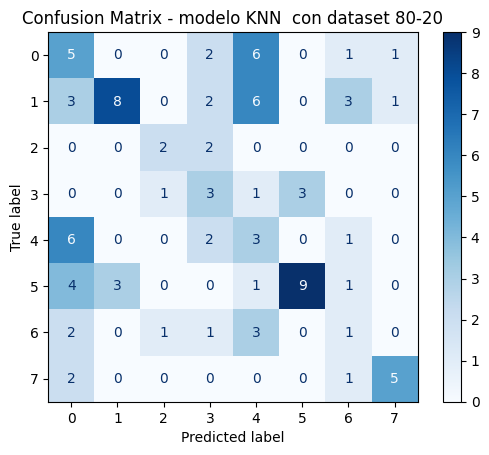

In [80]:
conf_matrix_knn_80 = confusion_matrix(y_test_20, y_pred_80_20)
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_80)
conf_matrix_disp.plot(cmap="Blues")
plt.title("Confusion Matrix - modelo KNN  con dataset 80-20") 

Observamos que el modelo no es capaz de predecir el valor de salida de forma correcta, ya que visualizamos los datos mezclados y no agrupados entre categorías. Tanto el scatter en 3D como la confusion matrix muestran que la clasificación es muy poco precisa.

Para el conjunto de datos 70-30

In [81]:
grid_search.fit(X_train_70_std, y_train_70)

print("Mejores parámetros:", grid_search.best_params_)

best_knn = grid_search.best_estimator_
y_pred_70_30 = best_knn.predict(X_test_30_std)

print("Resultados en el primer conjunto de prueba:")  
print(classification_report(y_test_30, y_pred_70_30))

print(f'Precision score: {precision_score(y_test_30, y_pred_70_30, average="macro")}')
print(f'Recall score: {recall_score(y_test_30, y_pred_70_30, average="macro")}')
print(f'accuracy_score: {accuracy_score(y_test_30, y_pred_70_30)}')

plot_classification_model(X_test_30_std, y_test_30, y_pred_70_30)

Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 11, 'p': 1}
Resultados en el primer conjunto de prueba:
              precision    recall  f1-score   support

        agua       0.30      0.38      0.33        24
       bicho       0.63      0.41      0.50        29
   electrico       0.25      0.60      0.35         5
       fuego       0.44      0.35      0.39        20
      hierba       0.30      0.29      0.29        21
      normal       0.55      0.46      0.50        24
    psiquico       0.15      0.22      0.18         9
        roca       0.57      0.67      0.62        12

    accuracy                           0.40       144
   macro avg       0.40      0.42      0.40       144
weighted avg       0.44      0.40      0.41       144

Precision score: 0.3992942090803933
Recall score: 0.421466201423098
accuracy_score: 0.4027777777777778


Text(0.5, 1.0, 'Confusion Matrix - modelo KNN  con dataset 70-30')

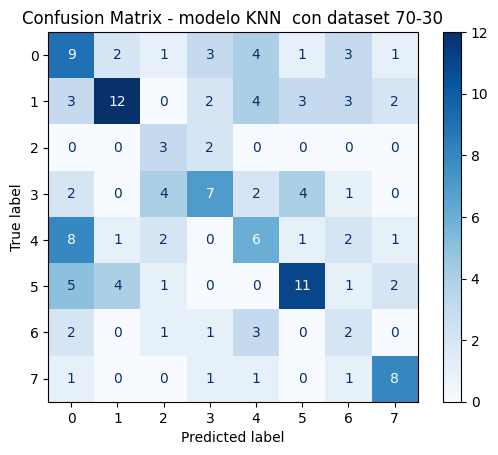

In [82]:
conf_matrix_knn_70 = confusion_matrix(y_test_30, y_pred_70_30)
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_70)
conf_matrix_disp.plot(cmap="Blues")
plt.title("Confusion Matrix - modelo KNN  con dataset 70-30") 

El escenario, una vez más, da cuentas que el modelo no es capaz de predecir las categorías de los pokemon de forma correcta.

## Conclusiones finales

**Compañías** 

Podemos ver la evolución del modelo conforme avanza el trabajo, ya que iniciamos con un modelo sobreajustado con la siguiente configuración y rendimiento: 
- Profundidad del árbol: 14
- Número de hojas: 795
- Número total de nodos: 1589
- R²: 0.9993753710020153


*Resultado de hacer el árbol de decisión de regresión lineal como modelo base, sin establecer restricciones*

Al establecer una profundidad máxima, y mínimos para separar nodos y hojas, se obtiene un modelo de mejor desempeño. A continuación mostramos uno de los dos mejores modelos encontrados:  
- Profundidad del árbol: 4
- Número de hojas: 16
- Número total de nodos: 31
- R²: 0.9952492203545034

Resulta, que incluso teniendo dos datasets distintos del mismo tamaño, el desempeño es prácticamente calcado. Se alcanzan los objetivos planteados y esperados para este caso. 
Es un modelo robusto que mostró su rendimiento y eficiencia en el proceso de predicción.

**Pokemons**

Para este ejercicio, evaluamos los modelos: 

- DecisionTreeClassifier.
- GaussianNB.
- KNeighborsClassifier. 

Aún separando el dataset en dos 4-tuplas que corresponden al 80% de datos de entrenamiento y el 20% de datos de test y otra con 70% para entrenamiento y 30% para test, no se evaluan cambios significativos en los modelos.

Entrar en los detalles de cada uno, con el rendimiento obtenido, casi carece de sentido. Sin embargo, podemos hacer algunas observaciones:

- El set de datos está desbalanceados, por lo que DecisionTreeClassifier con la bandera balance='balanced' corre con ventaja y se ve reflejada levemente en los resultados obtenidos. Por su parte KNeighborsClassifier, con la bandera weight='distance', es un caso similar, pero el rendimiento no sufre una mejora significativa.
- GaussianNB es un modelo de bayes simple, ingenuo, por ende era de esperar un rendimiento no muy bueno.

No encontramos un modelo robusto para predecir esta variable, más allá del desbalance de clases, los modelos deberían tener un rendimiento muy superior.